In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

import json
import pickle as pkl
import warnings
from typing import List

import numpy as np
import scipy
from hist import Hist

def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
! ls ../eos/

Apr25_fakes_2017                May27_fakes_cutbased_2017
Apr25_prompt_2017               May27_fakes_mva_2017
Feb9_2016                       May28_electronmva_nometcut_2017
Feb9_2016APV                    May30_2017
Feb9_2017                       May30_fakes_2017
Feb9_2018                       May30_uselooselep_2017
June11_LP_2016                  May31_fakes_2016
June11_LP_2016APV               May31_fakes_2016APV
June11_LP_2017                  May31_fakes_2017
June11_LP_2018                  May31_fakes_2018
June1_LPvalidation_2017         May31_hww_2016
June1_LPvalidation_2018         May31_hww_2016APV
May15_uselooselep_2016          May31_hww_2017
May15_uselooselep_2016APV       May31_hww_2018
May15_uselooselep_2017          May31_hww_uselooselep_2016
May15_uselooselep_2018          May31_hww_uselooselep_2016APV
May16_fakes_2016                May31_hww_uselooselep_2017
May16_fakes_2016APV             May31_hww_uselooselep_2018
May16_fakes_2017                May3_prompt_2017


In [4]:
! ls /Users/fmokhtar/Downloads/outfiles

ls: /Users/fmokhtar/Downloads/outfiles: No such file or directory


In [5]:
parquets = glob.glob("outfiles/0-20_*.parquet")

year = "2017"
parquets = glob.glob(f"../eos/June1_LPvalidation_{year}/*/outfiles/*.parquet")

# parquets = glob.glob(f"../eos/June11_LP_{year}/*/outfiles/*.parquet")

df = pd.read_parquet(parquets)
df["THWW"] = get_finetuned_score(df, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")
score = df["THWW"].values

In [6]:
for key in df:
    print(key)

fj_lsf3
fj_VScore
lep_pt
lep_eta
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
ht
n_bjets_L
n_bjets_M
n_bjets_T
NumFatjets
NumOtherJets
FirstFatjet_pt
FirstFatjet_eta
FirstFatjet_phi
FirstFatjet_msd
FirstFatjet_Vscore
SecondFatjet_pt
SecondFatjet_eta
SecondFatjet_phi
SecondFatjet_msd
SecondFatjet_Vscore
n_loose_electrons
n_tight_electrons
n_loose_muons
n_tight_muons
VH_fj_pt
VH_fj_eta
VH_fj_VScore
fj_pt
fj_eta
fj_phi
fj_mass
fj_ptJES_up
fj_ptJES_down
fj_ptJER_up
fj_ptJER_down
fj_ptJES_FlavorQCD_up
fj_ptJES_FlavorQCD_down
fj_ptJES_RelativeBal_up
fj_ptJES_RelativeBal_down
fj_ptJES_HF_up
fj_ptJES_HF_down
fj_ptJES_BBEC1_up
fj_ptJES_BBEC1_down
fj_ptJES_EC2_up
fj_ptJES_EC2_down
fj_ptJES_Absolute_up
fj_ptJES_Absolute_down
fj_ptJES_BBEC1_2017_up
fj_ptJES_BBEC1_2017_down
fj_ptJES_RelativeSample_2017_up
fj_ptJES_RelativeSample_2017_down
fj_ptJES_EC2_2017_up
fj_ptJES_EC2_2017_down
fj_ptJES_HF_2017_up
fj_ptJES_HF_2017_down
fj_ptJES_Absolute_2017_up
fj_ptJES_Absolute

In [200]:
print("          nquarks     counts")
for thresh in [0.0, 0.2,0.4,0.6,0.8]:
    print(f"THWW>{thresh}: ", np.unique(df["num_quarks"][score>thresh], return_counts=True)[0], np.unique(df["num_quarks"][score>thresh], return_counts=True)[1])

          nquarks     counts
THWW>0.0:  [0 2 4] [ 7600 65473 15382]
THWW>0.2:  [0 2 4] [ 1870 43189  2849]
THWW>0.4:  [0 2 4] [  944 35144  1737]
THWW>0.6:  [0 2 4] [  546 27989  1027]
THWW>0.8:  [0 2 4] [  218 18366   393]


In [201]:
print("        nquarks (matched)   counts")
for thresh in [0.0, 0.2,0.4,0.6,0.8]:
    print(f"THWW>{thresh}: ", np.unique(df["num_m_quarks"][score>thresh], return_counts=True)[0], np.unique(df["num_m_quarks"][score>thresh], return_counts=True)[1])

        nquarks (matched)   counts
THWW>0.0:  [0 1 2 3 4] [24411 25549 37359   844   292]
THWW>0.2:  [0 1 2 3 4] [ 3583 10877 32741   551   156]
THWW>0.4:  [0 1 2 3 4] [ 1786  6303 29213   413   110]
THWW>0.6:  [0 1 2 3 4] [  982  3547 24706   258    69]
THWW>0.8:  [0 1 2 3 4] [  376  1314 17137   119    31]


In [202]:
print("        nquarks (matched)   counts")
for thresh in [0.0, 0.2,0.4,0.6,0.8]:
    perc = (100*np.unique(df["num_m_quarks"][score>thresh], return_counts=True)[1]/np.unique(df["num_m_quarks"][score>thresh], return_counts=True)[1].sum()).round()
    print(f"THWW>{thresh}: ", np.unique(df["num_m_quarks"][score>thresh], return_counts=True)[0], f"{perc}%")

        nquarks (matched)   counts
THWW>0.0:  [0 1 2 3 4] [28. 29. 42.  1.  0.]%
THWW>0.2:  [0 1 2 3 4] [ 7. 23. 68.  1.  0.]%
THWW>0.4:  [0 1 2 3 4] [ 5. 17. 77.  1.  0.]%
THWW>0.6:  [0 1 2 3 4] [ 3. 12. 84.  1.  0.]%
THWW>0.8:  [0 1 2 3 4] [ 2.  7. 90.  1.  0.]%


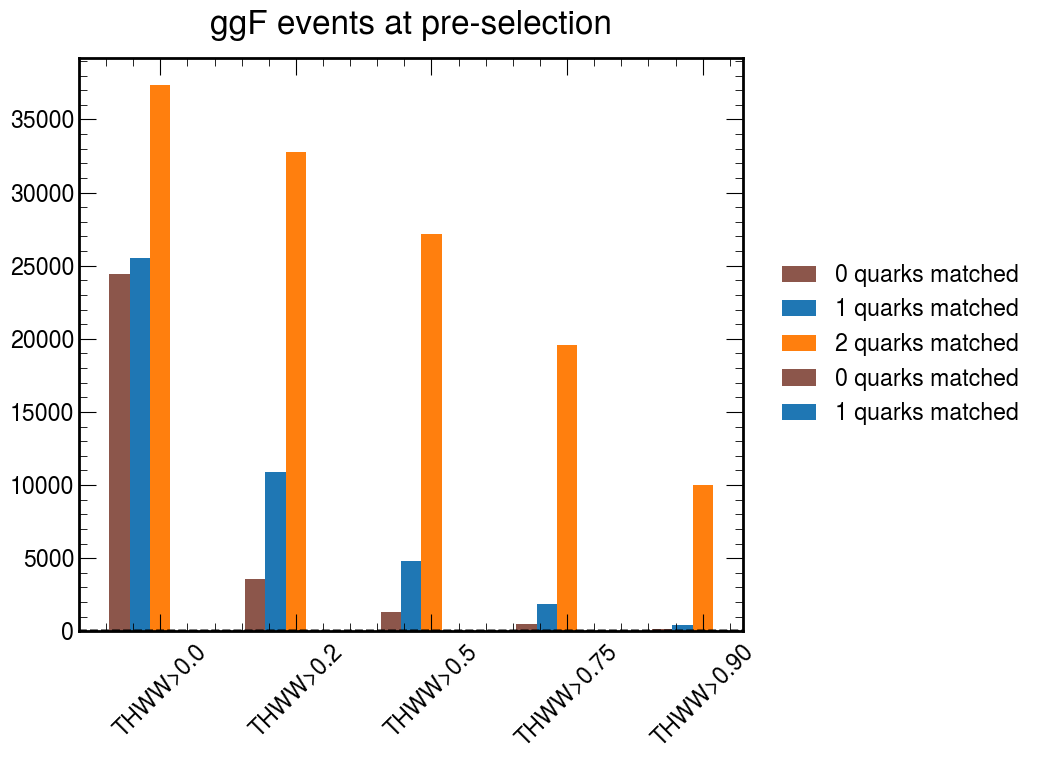

In [181]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

color_by_sample = {
    0: "tab:brown", 
    1: "tab:blue",
    2: "tab:orange",    
}

regions = [
    "THWW>0.0", 
    "THWW>0.2",
    "THWW>0.5",
    "THWW>0.75",
    "THWW>0.90",
]
samples = np.unique(df["num_m_quarks"][score>thresh], return_counts=True)[0]

bar_width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

for iregion, region in enumerate(regions):

    for i in range(3):

        X = np.unique(df["num_m_quarks"][score>float(region[-3:])], return_counts=True)[1][i]

        bars = ax.bar(iregion + i * bar_width, X, bar_width, color=color_by_sample[i], label=f"{i} quarks matched")

        ax.axhline(y=0, color='black', linestyle='--')

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:len(samples)], ax.get_legend_handles_labels()[1][:len(samples)]
ax.legend(handles, labels, loc='center right', bbox_to_anchor=(1.45, 0.5))


ax.set_title("ggF events at pre-selection", pad=17)

plt.tight_layout()
# plt.show()

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP_mquarks_sig.pdf")

In [141]:
print("        nquarks (matched)   counts")
for thresh in [0.0, 0.2, 0.5]:
    perc = (100*np.unique(df["fj_Top_nquarksnob"][score>thresh], return_counts=True)[1]/np.unique(df["fj_Top_nquarksnob"][score>thresh], return_counts=True)[1].sum()).round()
    print(f"THWW>{thresh}: ", np.unique(df["fj_Top_nquarksnob"][score>thresh], return_counts=True)[0], f"{perc}%")

        nquarks (matched)   counts
THWW>0.0:  [0 1 2 3 4] [92.  7.  1.  0.  0.]%
THWW>0.2:  [0 1 2 3] [71. 20.  9.  0.]%
THWW>0.5:  [0 1 2 3] [59. 23. 17.  0.]%


In [142]:
print("        nquarks (matched)   counts")
for thresh in [0.0, 0.2, 0.5]:
    perc = (np.unique(df["fj_Top_nquarksnob"][score>thresh], return_counts=True)[1]).round()
    print(f"THWW>{thresh}: ", np.unique(df["fj_Top_nquarksnob"][score>thresh], return_counts=True)[0], f"{perc}")

        nquarks (matched)   counts
THWW>0.0:  [0 1 2 3 4] [942365  72512  14736     70      6]
THWW>0.2:  [0 1 2 3] [57392 15812  7314    10]
THWW>0.5:  [0 1 2 3] [16532  6505  4810     5]


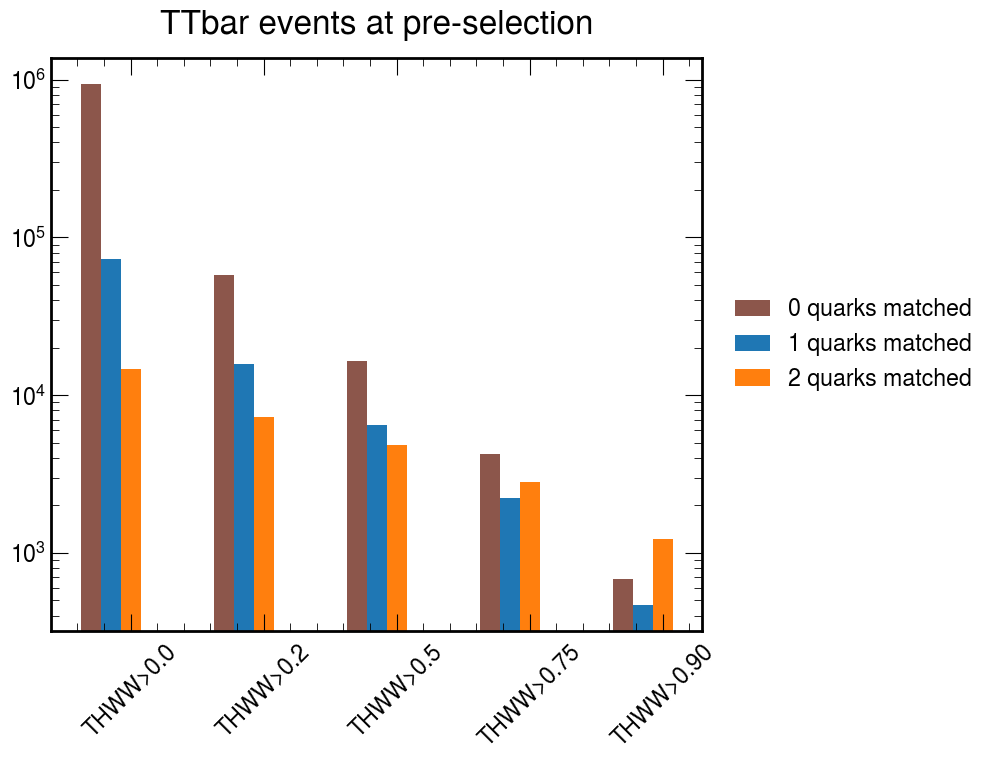

In [11]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

color_by_sample = {
    0: "tab:brown", 
    1: "tab:blue",
    2: "tab:orange",    
}

regions = [
    "THWW>0.0", 
    "THWW>0.2",
    "THWW>0.5",
    "THWW>0.75",
    "THWW>0.90",
]
samples = np.unique(df["fj_Top_nquarksnob"], return_counts=True)[0]

bar_width = 0.15

fig, ax = plt.subplots(figsize=(12, 8))

for iregion, region in enumerate(regions):

    for i in range(3):

        X = np.unique(df["fj_Top_nquarksnob"][score>float(region[-3:])], return_counts=True)[1][i]

        bars = ax.bar(iregion + i * bar_width, X, bar_width, color=color_by_sample[i], label=f"{i} quarks matched")

        ax.axhline(y=0, color='black', linestyle='--')

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:len(samples)-2], ax.get_legend_handles_labels()[1][:len(samples)]
ax.legend(handles, labels, loc='center right', bbox_to_anchor=(1.45, 0.5))


ax.set_title("TTbar events at pre-selection", pad=17)

plt.tight_layout()
# plt.show()
ax.set_yscale("log")

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP_mquarks_TTbar.pdf")

## Retrieve the pfcands, genquark, and ak8 jet info

In [167]:
year = "2018"
ch = "mu"

df = pd.read_parquet(f"df_{ch}_{year}.parquet")
df

,fj_lsf3,fj_VScore,lep_pt,lep_eta,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,...,LP_quark1_phi,LP_fj_pt,LP_fj_eta,LP_fj_phi,LP_fj_energy,fj_ParT_score,fj_ParT_mass,abs_met_fj_dphi,event_weight,THWW
111,0.588379,0.837016,200.956360,-0.142883,0.583889,0.000000,0.343070,47.033253,0.026642,133.361496,...,-2.492188,569.270386,-0.319627,-2.246879,278.514435,0.006437,92.209267,0.026642,0.165686,0.054546
140,0.854004,0.492218,514.362122,0.121567,0.654800,0.073635,0.161815,0.396144,0.155354,232.666290,...,1.488281,813.326965,0.053301,1.567721,141.468582,0.022010,181.851334,0.155354,0.169972,0.014792
191,0.920410,0.873307,133.554413,-0.037720,0.000000,0.000000,0.444200,82.359329,0.241325,112.518806,...,1.085938,279.361267,-0.060123,0.636011,128.546890,0.441896,207.180817,0.241325,0.175392,0.072275
224,0.885742,0.771182,114.062309,1.694580,0.025368,0.000000,0.363565,10.968716,0.480788,55.073589,...,2.632812,181.914856,1.833827,2.663207,89.283607,0.890156,201.908707,0.480788,0.173120,0.654611
238,0.779297,0.671094,88.617767,-0.454468,0.061231,0.000000,0.588136,24.132847,0.340129,56.953186,...,-1.722656,538.690247,0.231412,-1.822222,137.240234,0.956304,235.087997,0.340129,0.167048,0.117170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,0.844238,0.970726,90.970398,1.060059,0.084688,0.000000,0.254808,7.104085,-0.081316,106.949104,...,-0.810547,162.871582,1.436003,2.060736,42.943184,0.035790,160.226395,0.081316,0.221907,0.002345
3316,0.758301,0.948099,124.755394,0.670776,0.204454,0.188841,0.311149,79.181976,0.629136,62.614609,...,-0.716797,193.636459,0.776175,3.058538,68.969688,0.005324,137.566895,0.629136,0.226091,0.007236
3319,0.488281,0.897943,73.735680,0.026604,0.433076,0.139964,0.237039,35.248848,-0.599810,46.960636,...,1.660156,505.016144,0.297186,-1.762180,159.518906,0.027332,178.133820,0.599810,0.224672,0.015110
3322,0.521973,0.909985,66.480370,0.807983,0.365895,0.116490,0.201852,44.561073,0.944025,54.745834,...,-2.718750,196.722687,0.702012,0.453039,68.166458,0.003288,96.830208,0.944025,0.224283,0.016216


In [331]:
df = df[df["num_m_quarks"]==2]

In [12]:
df = df[df["fj_Top_nquarksnob"]==2]

In [13]:
# (1) PFcands

pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

print("pf_cands", pf_cands.shape)

pf_cands (14736, 150, 4)


In [14]:
# (2) ak8 jet, and the THWW score

ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_energy"].values], axis=-1)
print("ak8_jets", ak8_jets.shape)

print("THWW", df["THWW"].shape)

ak8_jets (14736, 4)
THWW (14736,)


In [15]:
# (3) genQuarks

etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

gen_parts_eta_phi = np.stack([etas,phis], axis=-1)
print("gen_parts_eta_phi (# events, # quarks, eta&phi)", gen_parts_eta_phi.shape)

gen_parts_eta_phi (# events, # quarks, eta&phi) (14736, 2, 2)


## Initiate a LundReweigher

In [16]:
import sys, os
sys.path.insert(0, '')
sys.path.append("LundReweighting")
from LundReweighting.utils.Utils import *

""" An example how to use the Lund Plane reweighting  code. 
Computes reweighting factors for an example signal. 
Uses them to compute the efficiency and uncertainty of a given substructure cut"""


######################## Setup 

#Input file 
fname = "LundReweighting/data/example_signal.h5"
f_ratio_name = 'LundReweighting/data/ratio_2017.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset 
d = Dataset(f_sig, dtype = 1)
d.compute_obs()

#The cut we will compute a SF for 'THWW>0.92

#Main class for reweighting utilities
LP_rw = LundReweighter(f_ratio = f_ratio)

#use small number of events for the example, but generally advisable to use larger sample

max_evts = -1

######## HWW
if max_evts == -1:
    pf_cands = pf_cands
    gen_parts_eta_phi = gen_parts_eta_phi
    ak8_jets = ak8_jets
else:
    pf_cands = pf_cands[:max_evts]
    gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]
    ak8_jets = ak8_jets[:max_evts]    

################### Compute reweighting factors

#PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
print("Running on %i events" % len(pf_cands))

#Nominal event weights of the MC, (assume every event is weight '1' for this example)
nom_weights = np.ones(len(pf_cands))

#Compute reweighting factors and all systematic variations
LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets, gen_parts_pdg_ids = None, distortion_sys=True, pf_cands_PtEtaPhiE_format=False)

#multiply Lund plane weights with nominal event weights
for key in LP_weights.keys():
    if('nom' in key or 'up' in key or 'down' in key):
        if(isinstance(LP_weights[key], np.ndarray)) : LP_weights[key] *= nom_weights


#Fraction of prongs that are not well matched to subjets (want this to be low)
print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
#Fraction of prongs that are still not well matched after reclustering with varied number of prongs
print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))

Welcome to JupyROOT 6.30/04
Running on 14736 events
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Reclustering into 0

Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! S

Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! Something went wrong
Reclustering into 0 subjets?! S

Bad match frac 0.50
Reclustered bad match frac 0.40


In [366]:
msk = []
for l in [x.subjet_match for x in LP_weights["reclust_nom"]]:
    if len(l)==2:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)
len(msk)

14736

In [374]:
(msk!=1).sum()

1150

In [363]:
sub_matching_bool = []
for x in np.array(LP_weights["reclust_nom"])[msk]:
    for y in x.subjet_match:
        sub_matching_bool.append(y)
sub_matching_bool = np.array(sub_matching_bool)
print("sub_matching_bool", sub_matching_bool.shape)

dRs = []
for x in np.array(LP_weights["reclust_nom"])[msk]:
    for y in x.subjet_dRs:
        dRs.append(y)
dRs = np.array(dRs)
print("dRs", dRs.shape)

sub_matching_bool (27172,)
dRs (27172,)


In [369]:
tot = msk.sum()*2
((msk!=1).sum() + len(dRs)) / tot

1.0423229795377595

13586

Text(1, 0, '$\\Delta$R(gen quark,subjet)')

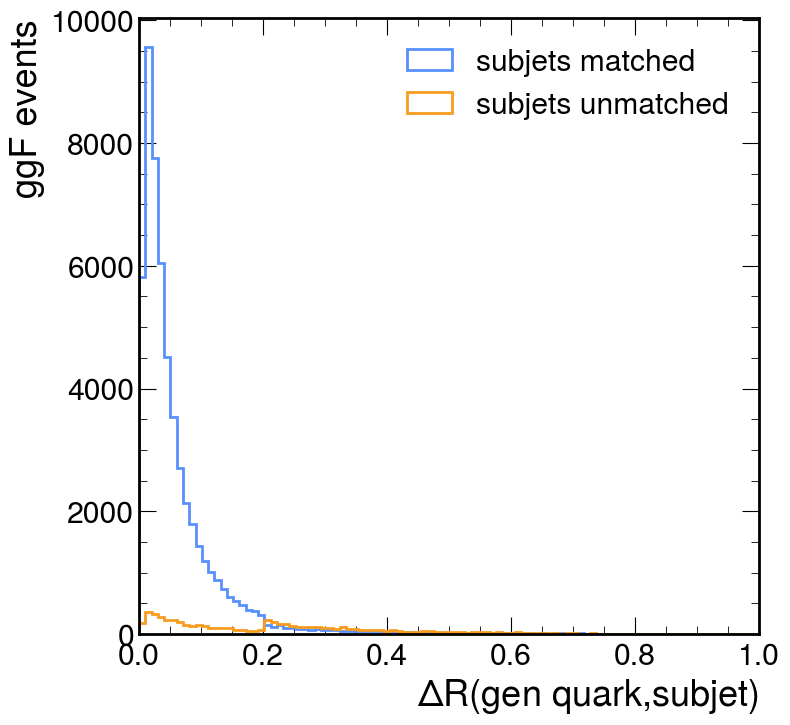

In [338]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(dRs[sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets matched")
ax.hist(dRs[~sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets unmatched")

ax.set_xlim(0,1)
ax.set_ylabel("TTbar events")
ax.legend()
ax.set_xlabel(r"$\Delta$R(gen quark,subjet)")

In [208]:
LP_weights["nom"].shape

(37359,)

In [209]:
LP_weights["nom"]

array([0.73024492, 1.16708584, 0.74874257, ..., 0.87880555, 1.11122473,
       0.64491165])

In [174]:
pd.DataFrame(LP_weights["nom"], columns=["LP_weight"]).to_parquet(f"LP_{ch}_{year}.parquet")

In [211]:
if max_evts == -1:
    score = df["THWW"].values
else:
    score = df["THWW"].values[:max_evts]
score_cut = score > 0.905

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = nom_weights)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights['nom'])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Other systematics come from up/down variations of the weights
sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]

#Print uncertainty breakdown
eff_str = "Calibrated efficiency  is %.2f +/- %.2f (stat) +/- %.2f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.2f/%.2f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2



tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5
print()
#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.2f, Calibrated %.2f +%.2f/-%.2f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

print(eff_str)
f_ratio.Close()

Nominal efficiency 0.255, Corrected efficiency 0.242, SF (corrected / nom) 0.951
Stat variation toys eff. avg 0.242, std dev 0.005
Pt variation toys eff. avg 0.242, std dev 0.000

Calibrated efficiency  is 0.24 +/- 0.01 (stat) +/- 0.00 (pt) 0.00/0.00 (sys) 0.00/0.00 (bquark) 0.00/-0.01 (prongs) -0.06/0.02 (unclust) 0.00/-0.01 (distortion)
 Original 0.26, Calibrated 0.24 +0.02/-0.06 

